In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import ot as pot
import math
from functools import partial

In [3]:
from src.energy_funcs import mw_energy
from src.vecfield import PEGNN_dynamics, MLP_dynamics
from src.optimizer import AdamWScheduleFree
from src.utils import ot_reordering
from src.manifolds import Euclidean, FlatTorus, ProductManifold
from src.integration import projx_integrator_return_last, output_and_div

# Classes and functions

In [4]:
def unwrap_positions(positions, eq_lattice, box):
    """Unwrap positions relative to the equilibrium lattice using integer image tracking.

    positions:  (T, N, 3)
    eq_lattice: (N, 3)
    box:        (3,)

    Returns: (T, N, 3) unwrapped positions
    """
    L = box.reshape(1, 1, 3)

    # Displacement from equilibrium
    disp = positions - eq_lattice.unsqueeze(0)  # (T, N, 3)

    # Integer image jumps per step (no float accumulation)
    d = torch.diff(disp, dim=0)                  # (T-1, N, 3)
    m = torch.round(d / L).long()       # integer images crossed each step
    M = torch.cumsum(m, dim=0)                   # cumulative images up to each frame

    # Expand to all frames (frame 0 has zero images)
    M_full = torch.zeros_like(disp, dtype=torch.long)
    M_full[1:] = M

    # Remove image crossings once; add back equilibrium
    disp_unwrapped = disp - L * M_full
    return eq_lattice.unsqueeze(0) + disp_unwrapped


def fix_com_to_eq_lattice(positions, eq_lattice):
    """Expects unwrapped positions"""
    eq_com = eq_lattice.mean(dim=0)
    pos_com = positions.mean(dim=1)
    shifts = eq_com - pos_com
    # return shifts
    positions_com_fix = positions + shifts.unsqueeze(1)
    return positions_com_fix

# Import dataset

We will only use the mW at 200K in the diamond cubic phase. The procedure is the same for every other dataset as well

In [5]:
TARGET_DATA_PATH = 'data/mW-cubic-N64-T200_small.npz'
target_data = np.load(TARGET_DATA_PATH)

for key in target_data.keys():
    print(f'  {key:12s} {str(target_data[key].shape):20s}')


  pos          (10000, 64, 3)      
  ene          (10000,)            
  box          (3, 3)              
  equi_lat     (64, 3)             


In [6]:
DTYPE = torch.float32

target_pos = torch.tensor(target_data['pos'], dtype=DTYPE)
eq_pos     = torch.tensor(target_data['equi_lat'], dtype=DTYPE)
box        = torch.diag(torch.tensor(target_data['box'], dtype=DTYPE))
box

tensor([1.2400, 1.2400, 1.2400])

In [7]:
# check if energies match
print(target_data['ene'][:3])
mw_energy(coordinates=target_pos[:3],
          box_length=box,
          unit_length='nm',
          unit_energy='kJ/mol')

[-3178.96847224 -3148.28233218 -3181.71775424]


tensor([-3178.9688, -3148.2830, -3181.7183])

In [8]:
PRIOR_SIGMA = 0.02
PRIOR_BETA = 1

prior_k = 1.0 / (2 * PRIOR_BETA * PRIOR_SIGMA ** 2)

kB_pre_2019 = 0.0019872067
TARGET_BETA = 1 / (kB_pre_2019 * 200)

In [9]:
n_particles = torch.tensor(64)
lambda_de_broglie = torch.tensor(0.23925)
volume = box[0]**3

first_term = 1. / n_particles * torch.log(n_particles * lambda_de_broglie**3. / volume)
second_term = 3./2. * (1 - 1. / n_particles) * torch.log(PRIOR_BETA * prior_k * lambda_de_broglie**2. / torch.pi)
third_term = -3. / (2. * n_particles) * torch.log(n_particles)

f_ec = first_term + second_term + third_term
f_ec

tensor(4.5056)

# Training with direct use of positions (Riemannian FM)

In [10]:
BS = 128
LR = 1e-4
DEVICE = 'cuda'

flow = PEGNN_dynamics(
    eq_pos=eq_pos,
    box_edges=box,
    rmin=0.2,
    rmax=0.5,
    box_edges_unit_cell=torch.tensor([0.62, 0.62, 0.62]),
    eq_pos_labeling_features=5,
    n_features_t=10,
    rbf_features=10,
    rbf_trainable=False,
    n_layers=10,
    hidden_nf=32,
).to(DEVICE)

optimizer = AdamWScheduleFree(flow.parameters(), LR)
optimizer.train()
loss_fn = nn.MSELoss()

In [11]:
loss_pegnn_pos = []
for _ in tqdm(range(5000)):
    # prepare prior samples
    prior_disp = torch.randn(BS, 64, 3) * PRIOR_SIGMA
    prior_disp = prior_disp - prior_disp.mean(dim=1).unsqueeze(1) # set com=0

    prior_pos = prior_disp + eq_pos
    x_0 = prior_pos % box
    x_0 = x_0.flatten(start_dim=1)

    # prepare target samples
    x_1 = target_pos[torch.randperm(len(target_pos))[:BS]].flatten(start_dim=1)


    # perform OT reordering
    i, j = ot_reordering(x_0, x_1, box)
    x_0, x_1 = x_0[i], x_1[j]


    t = torch.rand(len(x_1), 1)
    
    diff = (x_1 - x_0).view(-1, 64, 3)
    diff_pbc = diff - box * torch.round(diff / box)
    u_t_cond = diff_pbc.view(-1, 64 * 3)
    
    x_t = x_0 + t * u_t_cond

    optimizer.zero_grad()

    v_t = flow(t=t.to(DEVICE), x=x_t.to(DEVICE))
    l = loss_fn(v_t, u_t_cond.to(DEVICE))
    l.backward()
    loss_pegnn_pos.append(l.item())

    optimizer.step()

  0%|          | 0/5000 [00:00<?, ?it/s]

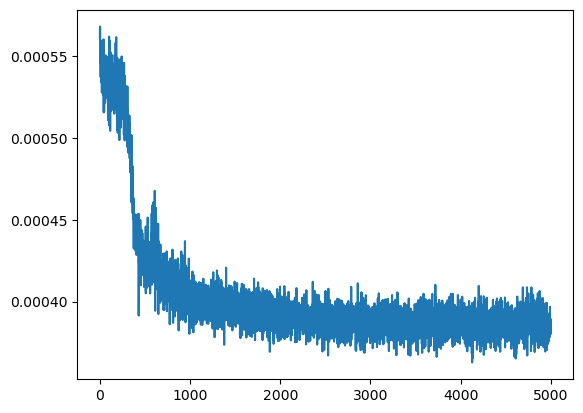

In [12]:
plt.plot(loss_pegnn_pos[:])

# Sample generation

In [13]:
ft = FlatTorus(64, 3, box)

def sample_with_dlogp(
    prior_samples,
    vecfield,
    manifold,
    integration_steps=11,
    integration_method='euler',
    div_mode='exact',
    k=1,
    device="gpu",
    pbar=True,
):
    vecfield.to(device)
    prior_samples = prior_samples.to(device)

    def odefunc(t, x, vecfield):
        x = x[..., :-1]  # leave out div
        vecfield_func = lambda x: vecfield(t, x)
        dx, div = output_and_div(vecfield_func, x, div_mode=div_mode, k=k)
        div = div.reshape(-1, 1)
        return torch.cat([dx, div], dim=-1)

    product_manifold = ProductManifold(manifold, Euclidean(1,1))
    state0 = torch.cat([prior_samples, torch.zeros_like(prior_samples[..., :1])], dim=-1)
    ts = torch.linspace(0, 1, integration_steps+1, device=device)


    state1 = projx_integrator_return_last(
                        manifold=product_manifold,
                        odefunc=partial(odefunc, vecfield=vecfield),
                        x0=state0,
                        t=ts,
                        method=integration_method,
                        pbar=pbar,
                    )

    transformed_samples, dlogp = state1[..., :-1], state1[..., -1:]
    return transformed_samples, dlogp


N_PRIOR_SAMPLES = 90
prior_disp = torch.randn(N_PRIOR_SAMPLES, 64, 3) * PRIOR_SIGMA
prior_disp = prior_disp - prior_disp.mean(dim=1).unsqueeze(1) # set com=0

prior_pos = prior_disp + eq_pos
prior_pos = prior_pos % box
prior_pos = prior_pos.flatten(start_dim=1)

torch.cuda.empty_cache()
transformed_samples, dlogp = sample_with_dlogp(
    prior_samples=prior_pos,
    vecfield=flow,
    manifold=ft,
    integration_steps=11,
    integration_method='rk4',
    div_mode='exact',
    k=10,
    device="cuda",
    pbar=True,
)

  0%|          | 0/11 [00:00<?, ?it/s]

# Free energy calculation

In [14]:
prior_energies = torch.sum(prior_k * prior_disp**2, dim=(-2, -1))
energies_transformed_samples = mw_energy(transformed_samples.reshape(-1, 64, 3), box, unit_length='nm')

log_weights = prior_energies.cpu().flatten() * PRIOR_BETA - TARGET_BETA * energies_transformed_samples.cpu().flatten() + dlogp.cpu().flatten()

In [15]:
def effective_sample_size(log_weights):
    """Kish effective sample size; log weights don't have to be normalized"""
    return torch.exp(2*torch.logsumexp(log_weights, dim=0) - torch.logsumexp(2*log_weights, dim=0))


def sampling_efficiency(log_weights):
    """Kish effective sample size / sample size; log weights don't have to be normalized
    Does not return percentage, but value in [0,1]
    """
    return effective_sample_size(log_weights) / len(log_weights)


def free_energy_diff(log_w):
    return - (torch.logsumexp(log_w, 0) - torch.log(torch.tensor(len(log_w))))


ref_f_mw64_cubic = -25.1631

ess_percent = sampling_efficiency(log_weights).item() * 100
df_value = free_energy_diff(log_weights).item() / 64
f_value = df_value + f_ec.item()

print(f"{'Effective Sample Size:':<30} {ess_percent:>8.2f}%")
print(f"{'Free Energy Difference (Δf):':<30} {df_value:>8.4f}")
print(f"{'Free Energy (f):':<30} {f_value:>8.4f}")
print(f"{'Reference (f_ref):':<30} {ref_f_mw64_cubic:>8.4f}")


Effective Sample Size:            33.09%
Free Energy Difference (Δf):   -29.6659
Free Energy (f):               -25.1603
Reference (f_ref):             -25.1631


Text(0.5, 1.0, 'log weights')

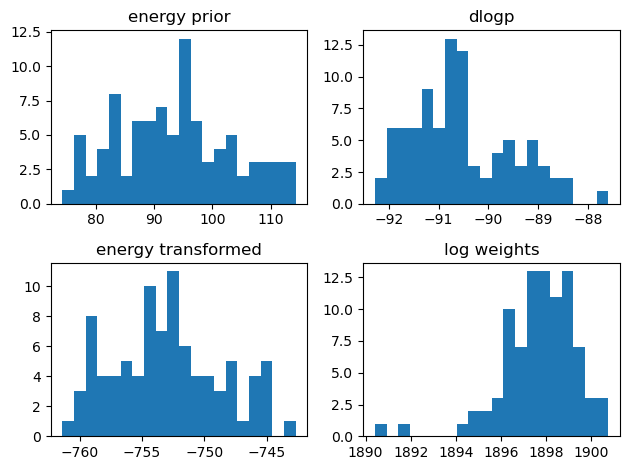

In [16]:
nbins=20
fig, axx = plt.subplots(2,2, tight_layout=True)

axx[0,0].hist(prior_energies.cpu().flatten(), bins=nbins)
axx[0,0].set_title('energy prior')
axx[1,0].hist(energies_transformed_samples.cpu().flatten(), bins=nbins)
axx[1,0].set_title('energy transformed')
axx[0,1].hist(dlogp.cpu().flatten(), bins=nbins)
axx[0,1].set_title('dlogp')
axx[1,1].hist(log_weights, bins=nbins)
axx[1,1].set_title('log weights')
